# Importing Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import nltk
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
import itertools
from wordcloud import WordCloud
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Reading the dataset and arranging the emails and labels into lists.

In [3]:
emails = []
labels = []
path = '/content/drive/MyDrive/email spam-20221122T202343Z-001/email spam/hamnspam/'

for label in ['ham','spam']:
    files = os.listdir(path + label)
    for file in files:
        f = open((path + label+'/' + file), 'r', encoding = 'latin-1')
        b = f.read()
        emails.append(b)
        labels.append(label)

# Creating a pandas dataset from the 2 lists for better convinence during data visualization and pre-processing

In [4]:
df = pd.DataFrame({'emails': emails, 'labels': labels})
df

,emails,labels
0,From fork-admin@xent.com Mon Oct 7 21:56:36 ...,ham
1,From rpm-list-admin@freshrpms.net Thu Aug 29 ...,ham
2,From fork-admin@xent.com Mon Sep 23 18:32:29 ...,ham
3,From exmh-users-admin@redhat.com Sat Sep 14 1...,ham
4,From fork-admin@xent.com Mon Sep 23 12:09:40 ...,ham
...,...,...
2945,Received: from timhunt.net (ns1.timhunt.net [2...,spam
2946,Received: from qrq.cc.ntu.edu.tw (giga.tw.free...,spam
2947,Received: from b.smtp-out.sonic.net (b.smtp-ou...,spam
2948,Received: from qrq.cc.ntu.edu.tw (giga.tw.free...,spam


# Visualizing data distribution.

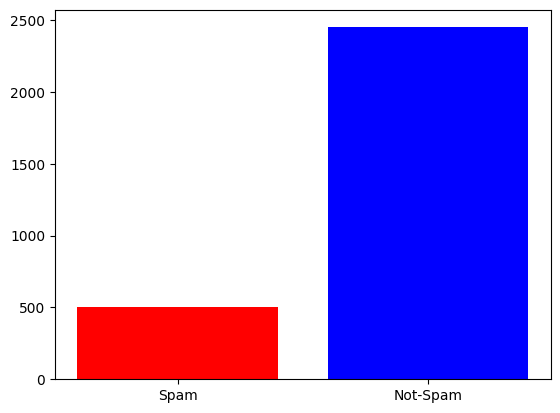

In [5]:
plt.bar('Spam', len(os.listdir('/content/drive/MyDrive/email spam-20221122T202343Z-001/email spam/hamnspam/spam')), color='r')
plt.bar('Not-Spam',len(os.listdir('/content/drive/MyDrive/email spam-20221122T202343Z-001/email spam/hamnspam/ham')), color='b')
plt.show()

# Visualizing most commonly used words

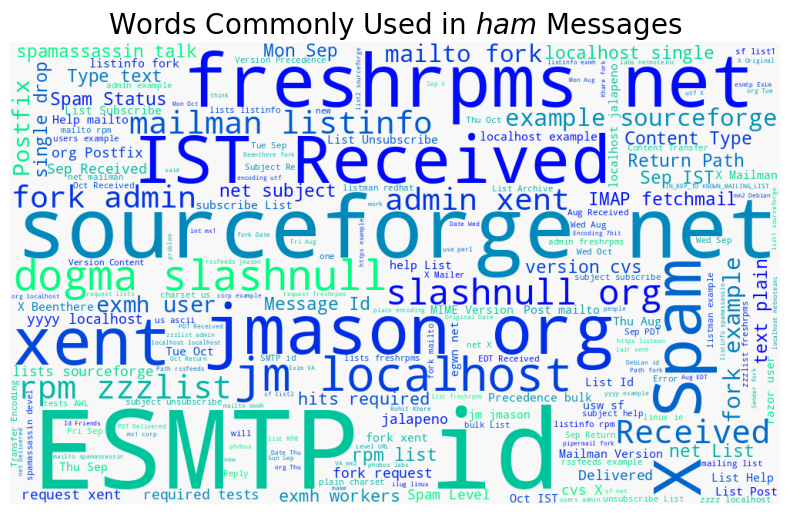

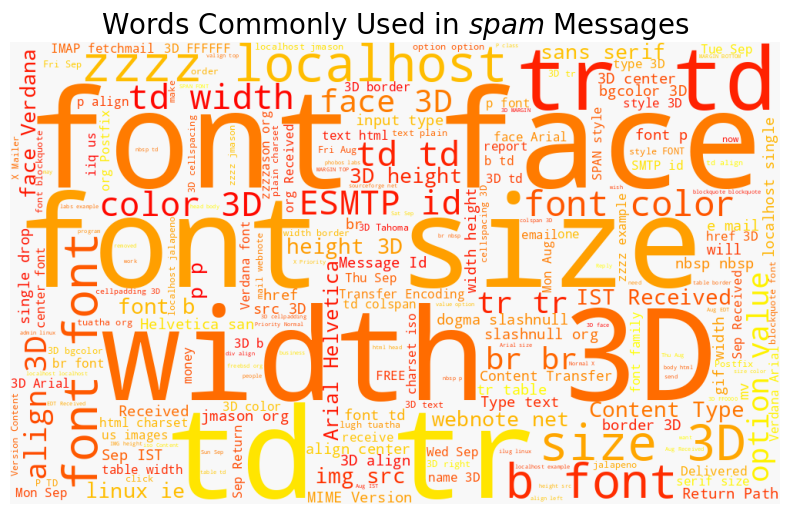

In [6]:
for label, cmap in zip(["ham", "spam"], ["winter", "autumn"]):
    text = df.query("labels == @label")["emails"].str.cat(sep=" ")
    plt.figure(figsize=(10, 6))
    wc = WordCloud(width=1000, height=600, background_color="#f8f8f8", colormap=cmap)
    wc.generate_from_text(text)
    plt.imshow(wc)
    plt.axis("off")
    plt.title(f"Words Commonly Used in ${label}$ Messages", size=20)
    plt.show()

# Visualizing the length disstribution of the content in the emails.

<ipython-input-7-4d616fec8c30>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['length']).set_title('email length distribution')


Text(0.5, 1.0, 'email length distribution')

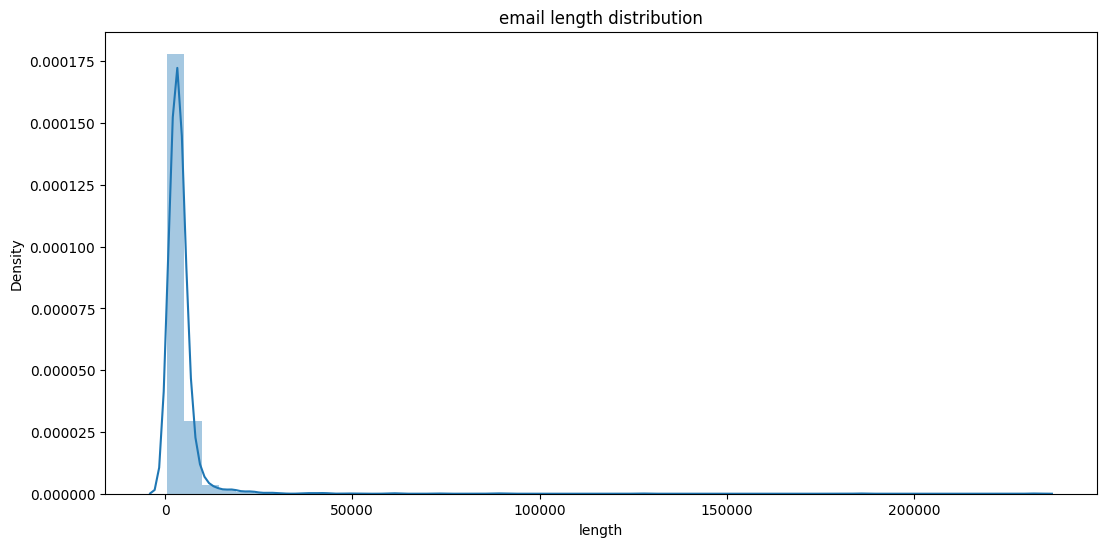

In [7]:
df['length'] = df['emails'].str.len()
plt.figure(figsize=(12.8,6))
sns.distplot(df['length']).set_title('email length distribution')

In [8]:
df['length'].describe()

count      2950.000000
mean       4233.340000
std        7383.101283
min         493.000000
25%        2166.250000
50%        3413.000000
75%        4521.000000
max      232337.000000
Name: length, dtype: float64

# removing from the 95% percentile onwards to better understanding of the histogram:

In [9]:
quantile_95 = df['length'].quantile(0.95)
df_95 = df[df['length'] < quantile_95]

<ipython-input-10-76e80548957e>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_95['length']).set_title('email length distribution');


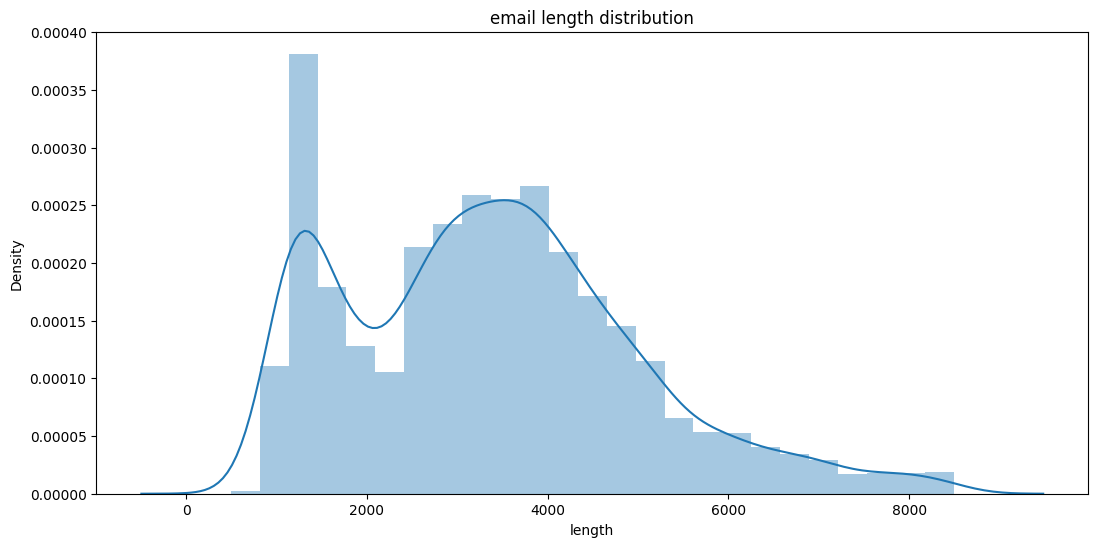

In [10]:
plt.figure(figsize=(12.8,6))
sns.distplot(df_95['length']).set_title('email length distribution');

# Visualizing using boxplot

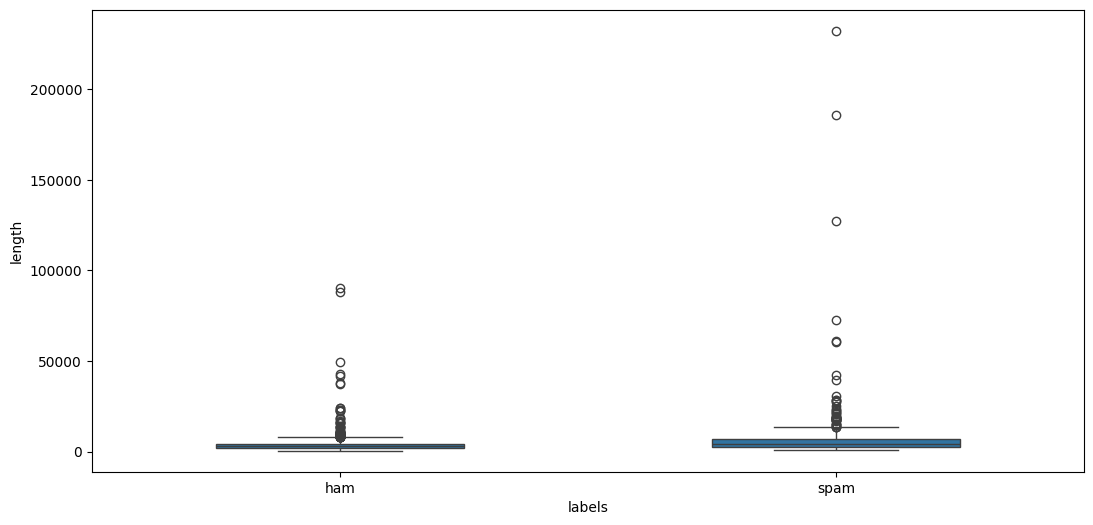

In [11]:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=df, x='labels', y='length', width=.5);

# Visualizing after removing from the 95% percentile onwards to better understanding of the boxplot:

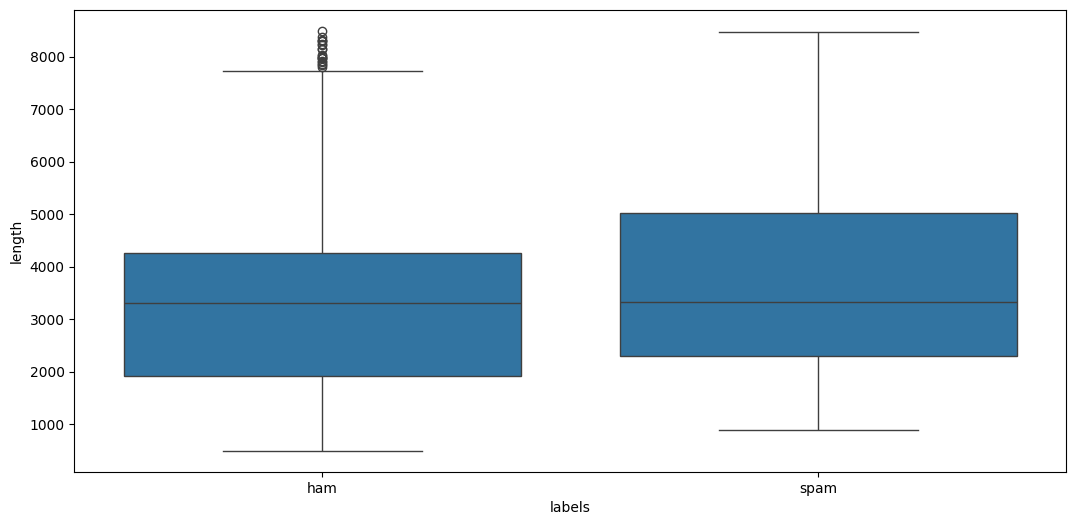

In [12]:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=df_95, x='labels', y='length');

# Checking for missing data

In [13]:
print(df.isnull().sum())

emails    0
labels    0
length    0
dtype: int64


#### there is no missing data

# Converting the data into lower case.

In [14]:
df['emails'] = df['emails'].apply(lambda x:x.lower())

# removing punctuations

In [15]:
punctuation_signs = list("?:!.,;")
df['emails'] = df['emails']

for punct_sign in punctuation_signs:
    df['emails'] = df['emails'].str.replace(punct_sign, '')

# removing words with small lengths

In [16]:
for i in range(len(df)):
    long_words=[]
    for j in df['emails'][i].split():
        if len(j)>=3:
            long_words.append(j)
    df['emails'][i]=" ".join(long_words)

Streaming output truncated to the last 5000 lines.
<ipython-input-16-b2864982997f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['emails'][i]=" ".join(long_words)
<ipython-input-16-b2864982997f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['emails'][i]=" ".join(long_words)
<ipython-input-16-b2864982997f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['emails'][i]=" ".join(long_words)
<ipython-input-16-b2864982997f>:6:

# Removing '\n' and '\t'.

In [17]:
df['emails'] = df['emails'].apply(lambda x: x.replace('\n', ' '))
df['emails'] = df['emails'].apply(lambda x: x.replace('\t', ' '))

# Removing extra spaces

In [18]:
df['emails'] = df['emails'].str.replace("    ", " ")

# Removing quoting text

In [19]:
df['emails'] = df['emails'].str.replace('"', '')

# removing progressive pronouns

In [20]:
df['emails'] = df['emails'].str.replace("'s", "")

# Lemmatization

In [21]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [22]:
wordnet_lemmatizer = WordNetLemmatizer()

In [23]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [24]:
nrows = len(df)
lemmatized_text_list = []
for row in range(0, nrows):

    # Create an empty list containing lemmatized words
    lemmatized_list = []

    # Save the text and its words into an object
    text = df.loc[row]['emails']
    text_words = str(text).split(" ")

    # Iterate through every word to lemmatize
    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))

    # Join the list
    lemmatized_text = " ".join(lemmatized_list)

    # Append to the list containing the texts
    lemmatized_text_list.append(lemmatized_text)

In [25]:
df['emails'] = lemmatized_text_list

# Removing Stop-words

In [26]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [27]:
stop_words = list(stopwords.words('english'))

In [28]:
for stop_word in stop_words:
    regex_stopword = r"\b" + stop_word + r"\b"
    df['emails'] = df['emails'].str.replace(regex_stopword, '')

In [29]:
kk = df['emails'].values

In [30]:
kk

array(["from fork-admin@xentcom mon oct 215636 2002 return-path <fork-admin@xentcom> delivered-to yyyy@localhostexamplecom receive from localhost (jalapeno [127001]) jmasonorg (postfix) with esmtp d86a616f18 for <jm@localhost> mon oct 2002 215613 +0100 (ist) receive from jalapeno [127001] localhost with imap (fetchmail-590) for jm@localhost (single-drop) mon oct 2002 215613 +0100 (ist) receive from xentcom ([6416122236]) dogmaslashnullorg (8116/8116) with esmtp g97jjsk14541 for <jm@jmasonorg> mon oct 2002 204555 +0100 receive from lairxentcom (localhost [127001]) xentcom (postfix) with esmtp 793592940d5 mon oct 2002 124503 -0700 (pdt) delivered-to fork@examplecom receive from sunserverpermafrostnet (u172n16hfxeastlinkca [2422217216]) xentcom (postfix) with esmtp 4fcb52940d4 for <fork@xentcom> mon oct 2002 124419 -0700 (pdt) receive from [192168123179] (helo=permafrostnet) sunserverpermafrostnet with esmtp (exim 336 (debian)) 17ydfa-00074d-00 mon oct 2002 163558 -0300 message-id <3da1e5

# Encoding labels by converting 'ham' to 0 and 'spam' to 1.

In [31]:
encoder = LabelEncoder()
df['labels'] = encoder.fit_transform(df['labels'])

# Using Bag of Words approach for final data Preparation.

In [32]:
cv = CountVectorizer(max_features = 2500)
X = cv.fit_transform(df['emails']).toarray()
y = df['labels']

# Splitting the Data using Stratified split

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state = 42)

In [34]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                              cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Using MultiNomial Naive Bayes as the Model and printing evaluating it using confusion matrix

accuracy is:  0.9796610169491525


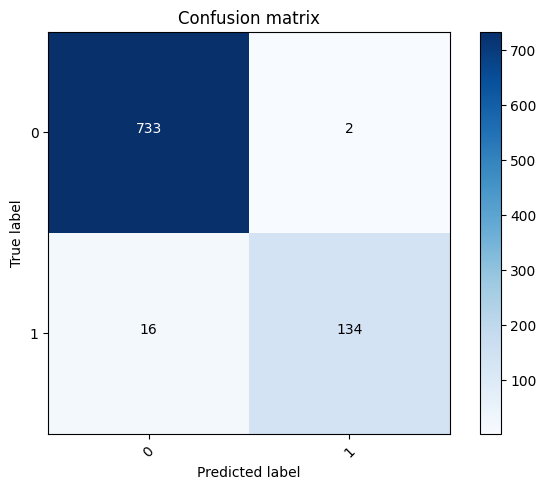

In [35]:
clf1 = MultinomialNB()
clf1.fit(X_train, y_train)
y_pred = clf1.predict(X_test)
accuracy_NB = accuracy_score(y_test, y_pred)
print("accuracy is: ",accuracy_NB)
CM = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(CM, classes = range(2))

In [36]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       735
           1       0.99      0.89      0.94       150

    accuracy                           0.98       885
   macro avg       0.98      0.95      0.96       885
weighted avg       0.98      0.98      0.98       885



# Using SVC as the Model and printing evaluating it using confusion matrix

accuracy is:  0.9887005649717514


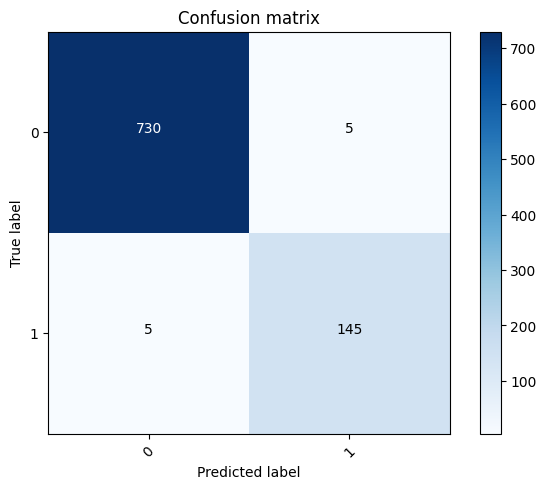

In [37]:
clf2 = SVC(kernel='rbf', probability=True)
clf2 = clf2.fit(X_train, y_train)
y_pred = clf2.predict(X_test)
accuracy_SVM = accuracy_score(y_test, y_pred)
print("accuracy is: ",accuracy_SVM)
CM = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(CM, classes = range(2))

In [38]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       735
           1       0.97      0.97      0.97       150

    accuracy                           0.99       885
   macro avg       0.98      0.98      0.98       885
weighted avg       0.99      0.99      0.99       885



# Using KNeighbors Classifier as the Model and printing evaluating it using confusion matrix

accuracy is:  0.9774011299435028


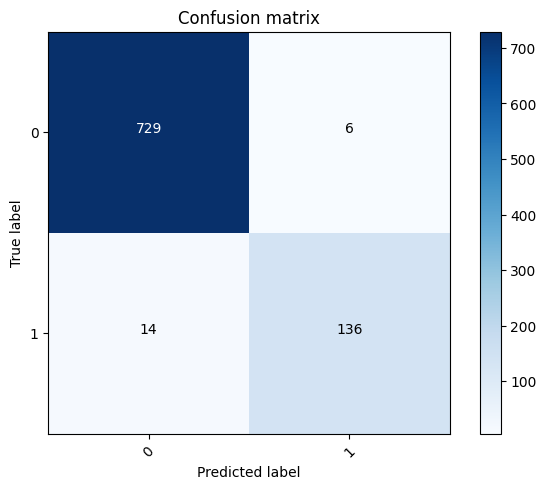

In [39]:
clf3 = KNeighborsClassifier(n_neighbors=7)
clf3 = clf3.fit(X_train, y_train)
y_pred = clf3.predict(X_test)
accuracy_KNN = accuracy_score(y_test, y_pred)
print("accuracy is: ",accuracy_KNN)
CM = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(CM, classes = range(2))

In [40]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       735
           1       0.96      0.91      0.93       150

    accuracy                           0.98       885
   macro avg       0.97      0.95      0.96       885
weighted avg       0.98      0.98      0.98       885



<Figure size 1000x800 with 0 Axes>

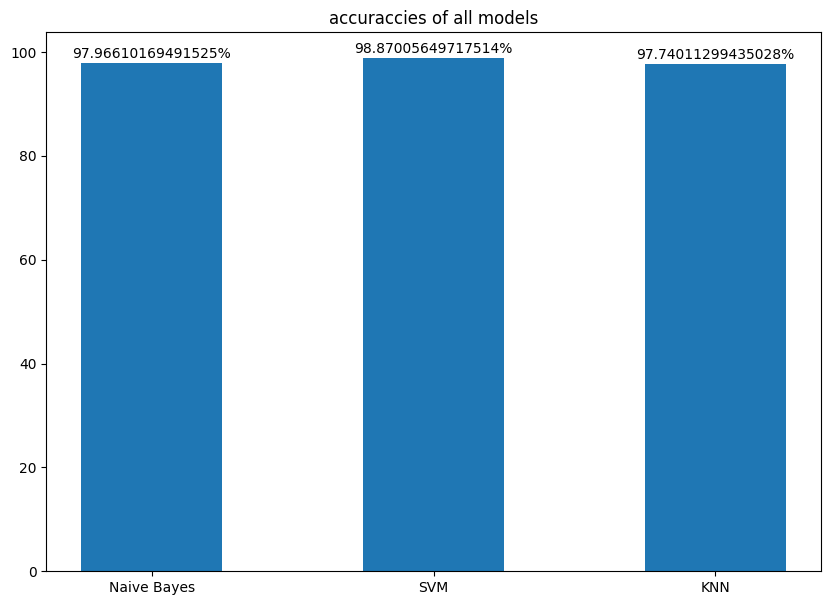

In [41]:
x =models = ['Naive Bayes','SVM','KNN']
y = accuracy = [accuracy_NB*100, accuracy_SVM*100,accuracy_KNN*100]
width = 0.5
plt.figure(figsize=(10,8))
fig, ax = plt.subplots(figsize=(10,7))

pps = ax.bar(x, y, width, align='center')

for p in pps:
   height = p.get_height()
   ax.text(x=p.get_x() + p.get_width() / 2, y=height+1,
      s="{}%".format(height),
      ha='center')
# plt.ylim([50, 100])

plt.title('accuraccies of all models')
plt.show()


# Predictions

In [42]:
em=pd.Series([ 'Sounds great! Are you home now?'])

In [43]:
r = cv.transform(em).toarray()

In [44]:
p=clf1.predict(r)

In [45]:
if p==0:
    print("Ham")
else:
    print("Spam")

Spam


In [46]:
X_test

array([[1, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 2, ..., 0, 0, 0],
       [0, 0, 0, ..., 7, 0, 0],
       [0, 0, 0, ..., 4, 0, 0]])

In [47]:
df['emails'].values

array(["from fork-admin@xentcom mon oct 215636 2002 return-path <fork-admin@xentcom> delivered-to yyyy@localhostexamplecom receive from localhost (jalapeno [127001]) jmasonorg (postfix) with esmtp d86a616f18 for <jm@localhost> mon oct 2002 215613 +0100 (ist) receive from jalapeno [127001] localhost with imap (fetchmail-590) for jm@localhost (single-drop) mon oct 2002 215613 +0100 (ist) receive from xentcom ([6416122236]) dogmaslashnullorg (8116/8116) with esmtp g97jjsk14541 for <jm@jmasonorg> mon oct 2002 204555 +0100 receive from lairxentcom (localhost [127001]) xentcom (postfix) with esmtp 793592940d5 mon oct 2002 124503 -0700 (pdt) delivered-to fork@examplecom receive from sunserverpermafrostnet (u172n16hfxeastlinkca [2422217216]) xentcom (postfix) with esmtp 4fcb52940d4 for <fork@xentcom> mon oct 2002 124419 -0700 (pdt) receive from [192168123179] (helo=permafrostnet) sunserverpermafrostnet with esmtp (exim 336 (debian)) 17ydfa-00074d-00 mon oct 2002 163558 -0300 message-id <3da1e5

In [48]:
spm = []
hm = []

In [49]:
for sent in kk:
  em=pd.Series([str(sent)])
  r = cv.transform(em).toarray()
  p=clf1.predict(r)
  if p==0:
    print("Ham")
    hm.append(sent)
  else:
    print("Spam")
    spm.append(sent)
    print(sent)


Output hidden; open in https://colab.research.google.com to view.

In [50]:
print(spm,end="\n")

Output hidden; open in https://colab.research.google.com to view.

In [51]:
s1 = ' zahrae@email2qvesnet tue aug 121923 2002 return-path <zahrae@email2qvesnet> delivered- zzzz@localhostexamplecom receive  localhost (localhost [127001]) phoboslabsexamplecom (postfix)  esmtp 98b8943f99  <zzzz@localhost> tue aug 2002 071923 -0400 (edt) receive  mailwebnotenet [193120211219] localhost  pop3 (fetchmail-590)  zzzz@localhost (single-drop) tue aug 2002 121923 +0100 (ist) receive  smtpeasydnscom (smtpeasydnscom [2052104230]) webnotenet (893/893)  esmtp maa31139  <zzzz@examplecom> tue aug 2002 121547 +0100 receive  emailqvescom (unknown [6710483251]) smtpeasydnscom (postfix)  esmtp 117dd2e06d  <zzzz@examplecom> tue aug 2002 071545 -0400 (edt) receive  qvp0078 ([16925467]) emailqvescom  microsoft smtpsvc(5021953779) tue aug 2002 051334 -0600  hot hot <zahrae@email2qvesnet> <zzzz@examplecom> subject join  web hottest fastest grow community 1170 date tue aug 2002 051334 -0600 message-id <74ab201c24dba$c89a5ad0$0706fea9@freeyankeedomcom> mime-version x-mailer microsoft cdo  windows 2000 thread-index acjnusiab0tdxmtxr+wv0vghbwi8lg== content-class urncontent-classesmessage x-mimeole produce microsoft mimeole v60024620000 x-originalarrivaltime aug 2002 1113340460 (utc) filetime=[c89a33c001c24dba] content-type multipart/alternative boundary=----=_nextpart_000_74ab3_01c24d887dffead0  multi-part message mime format ------=_nextpart_000_74ab3_01c24d887dffead0 content-type text/plain charset=iso-8859-1 content-transfer-encoding 7bit join  web hottest fastest grow community hot <http//wwwadclickws/pcfmo=259&=pk007> guarantee lose 10-12 lbs days slim patch weight loss patch <http//wwwadclickws/pcfmo=249&=pk007> get  child support  deserve free legal advice <http//wwwadclickws/pcfmo=245&=pk002>  wonderful day offer manager <http//wwwqvescom/trim/zzzz@examplecom%7c17%7c308417> ------=_nextpart_000_74ab3_01c24d887dffead0 content-type text/html charset=iso-8859-1 content-transfer-encoding quoted-printable <html> <body bgcolor=3d#ffffff text=3d#000000> join  web hottest fastest grow community<br> href=3dhttp//wwwadclickws/pcfmo=3d259&=3dpk007 target=3d_blank> =20 hot</><br> <br> guarantee lose 10-12 lbs days<br> href=3dhttp//wwwadclickws/pcfmo=3d249&=3dpk007 target=3d_blank>slim=20 patch weight loss patches</><br> <br> get  child support  deserve<br> href=3dhttp//wwwadclickws/pcfmo=3d245&=3dpk002 target=3d_blank>free=20 legal advice</><br> <br>  wonderful day <br> offer manager<br> <br><br><br><br><br><br><br><br><br><br><center>< href=3dhttp//wwwqvescom/trim/zzzz@examplecom%7c17%7c308417><img border=3d0 src=3dhttp//209631519/trim/17%7c306356%7c6644></></center></body>= </html> ------=_nextpart_000_74ab3_01c24d887dffead0--'

s2 = 'jani@topmaildk tue aug 083258 2002 return-path <jani@topmaildk> delivered- zzzz@localhostexamplecom receive  localhost (localhost [127001]) phoboslabsexamplecom (postfix)  esmtp 4434943f99  <zzzz@localhost> tue aug 2002 033258 -0400 (edt) receive  mailwebnotenet [193120211219] localhost  pop3 (fetchmail-590)  zzzz@localhost (single-drop) tue aug 2002 083258 +0100 (ist) receive  smtpeasydnscom (smtpeasydnscom [2052104230]) webnotenet (893/893)  esmtp iaa30199 tue aug 2002 083019 +0100  jani@topmaildk receive  topmaildk (saborprosabormexcommx [200365484]) smtpeasydnscom (postfix)  smtp 6f8362dae5 tue aug 2002 033013 -0400 (edt) receive  m10grpsnvyahoocom ([43250309]) smtp4cybereccom  qmqp tue aug 2002 193307 -1000 receive  web13708mailyahoocom ([8823810715]) mailgmxnet  nnfmp mon aug 2002 213049 +1200 receive  unknown (1532451905) smtp-server1cflrrcom  smtp aug 2002 042832 +0500 reply- <jani@topmaildk> message-id <008e45b47bde$5627d8c0$0ee03ad6@vjsxnm> alan3@hotmailcom subject help want work  home reps mime-version x-priority (normal) x-msmail-priority normal x-mailer egroups message poster importance normal date tue aug 2002 033013 -0400 (edt) content-type multipart/mixed boundary=----=_nextpart_000_00c3_65e56b8db3612a36 ------=_nextpart_000_00c3_65e56b8db3612a36 content-type text/plain charset=iso-8859-1 content-transfer-encoding base64 sgvsccb3yw50zwquicbxzsbhcmugysaxncb5zwfyig9szcbmb3j0dw5liduw mcbjb21wyw55lcb0agf0iglzdqpncm93aw5nigf0igegdhjlbwvuzg91cyby yxrlliagv2ugyxjligxvb2tpbmcgzm9yigluzgl2awr1ywxzihdobw0kd2fu dcb0byb3b3jrigzyb20gag9tzs4ncg0kvghpcybpcybhbibvchbvcnr1bml0 esb0bybtywtligfuigv4y2vsbgvudcbpbmnvbwuuicbobyblehblcmllbmnl dqppcybyzxf1axjlzc4gifdlihdpbgwgdhjhaw4gew91lg0kdqptbybpzib5 b3ugyxjligxvb2tpbmcgdg8gymugzw1wbg95zwqgznjvbsbob21lihdpdggg ysbjyxjlzxigdghhdcboyxmncnzhc3qgb3bwb3j0dw5pdgllcywgdghlbibn bzoncg0kahr0cdovl3d3dy5iyxnldgvslmnvbtoynzawmc93zwfsdghub3cn cg0kv2ugyxjligxvb2tpbmcgzm9yigvuzxjnzxrpyybhbmqgc2vszibtb3rp dmf0zwqgcgvvcgxlliagswygdghhdcbpcyb5b3uncnroyw4gy2xpy2sgb24g dghligxpbmsgyw5kigzpbgwgb3v0ihrozsbmb3jtlcbhbmqgb25lig9mig91 cg0kzw1wbg95zw1lbnqgc3bly2lhbglzdcb3awxsignvbnrhy3qgew91lg0k dqpubybizsbyzw1vdmvkigzyb20gb3vyigxpbmsgc2ltcgxligdvihrvog0k dqpodhrwoi8vd3d3lmjhc2v0zwwuy29tl3jlbw92zs5odg1sdqoncg=='



In [52]:
s3 = '''webster@ryanairmailcom mon sep 123045 2002 return-path <webster@ryanairmailcom> delivered- zzzz@localhostnetnoteinccom receive  localhost (localhost [127001]) phoboslabsnetnoteinccom (postfix)  esmtp 1b3b143f9b  <zzzz@localhost> mon sep 2002 073037 -0400 (edt) receive  phobos [127001] localhost  imap (fetchmail-590)  zzzz@localhost (single-drop) mon sep 2002 123037 +0100 (ist) receive  mailryanair2ie ([1931201528]) dogmaslashnullorg (8116/8116)  smtp g7ulmqz08782  <zzzz-ryanair@examplecom> fri aug 2002 222236 +0100  webster@ryanairmailcom customers <customers@mailryanairmailcom> subject save 70% international call date fri aug 2002 174252 +0100 x-assembled- xwall v321 message-id <listmanager-949326-32914-20020830-174731--zzzz-ryanair#examplecom@mailryanairmailcom> mime-version content-type multipart/mixed boundary=_nextpart_1_bvfoditvghtocxfdvjnkcuwblfv list-unsubscribe <mailtoleave-customers-949326k@mailryanairmailcom> reply- webster@ryanairmailcom  multi part message mime format --_nextpart_1_bvfoditvghtocxfdvjnkcuwblfv content-type text/plain charset=us-ascii content-transfer-encoding 7bit   telecoms partner bumblebee ' get rip  expensive hotel payphone  mobile charge save save save international call  ryanair phone partner ************************************************************************ ********* ' save 70% international phone call   use  online phone card   use  card   phone  country  visit   '  worry  high phone charge   call home  office buy card ' easier   totally secure simply http//wwwbumblebeecommunicationscom/lowcostcalls/ avail  special offer  ryanair customers  another great deal  ryanair   online phone partner bumblebee communications ===================================================================== e-mail disclaimer  e-mail   file  attachments transmit   confidential  may legally privilege   intend solely   use  intend recipient  view  opinions express    individual author/sender    necessarily share endorse ryanair hold plc  associate relate company particular e-mail transmissions   bind   purpose form contract sell airline seat directly via promotions   form contractual obligation  type  contract   form write post fax duly sign senior company executive subject approval  board directors  content  e-mail  file attachment transmit  may   change alter without  consent  author     intend recipient  e-mail   hereby notify   review dissemination disclosure alteration print circulation transmission  action take omit reliance  e-mail  file attachment transmit  prohibit  may unlawful   receive  e-mail error please notify ryanair hold plc email postmaster@ryanairie contact ryanair hold plc dublin airport dublin ireland --_nextpart_1_bvfoditvghtocxfdvjnkcuwblfv content-type application/ms-tnef content-transfer-encoding base64 ej8+ijuqaqaqcaaeaaaaaaabaaeaaqeqbgaiaaaa5aqaaaaaaadoaaeigacagaaaaelqts5nawny b3nvznqgtwfpbc5ob3rladeiaq2abaacaaaaagacaaeegaeajwaaafnhdmugdxagdg8gnzalig9u igludgvybmf0aw9uywwgy2fsbhmhacgnaqwaawaoaaaa0gciab4aeqaqadqabqbzaqeggamadgaa anihcaaeabeakga0aauacwebcyabaceaaaaxnundqzu1m0zcnjvgotrcodjbote2nji0qjy5odi2 naagbwedkayayagaadeaaaalaaiaaqaaaamajgaaaaaaawa2aaaaaabaadkaohxzserqwgeead0a aqaaaaeaaaaaaaaaagfhaaeaaaayaaaayz11czthpsa7cd1sewfuywlyo2w9q0hpvk1bsuwxltay mdgzmde2ndi1mlotnty1ngaaab4acaabaaaajwaaafnhdmugdxagdg8gnzalig9uigludgvybmf0 aw9uywwgy2fsbhmhaaacaxeaaqaaabyaaaabwlbesgnvr3xmdo5jp7lazao6pgd8aaaeabomaqaa aawaaabdb3lszswgu2vhbgaeab0oaqaaaccaaabtyxzlihvwihrvidcwjsbvbibpbnrlcm5hdglv bmfsignhbgxziqaaagejeaeaaac7agaatwiaalseaabmwkz1tpw4mgmacgbyy3bnmti14jidq3rl eavbaqmb908kgakka+mcagnocsbz8gv0mcahewkad/mauh8evghvb7irxq5raweqxzl3bgagwxhf mwrgemks2xht2wjvcfc7gl8omdurwgxgzmmauasjawqznhfqc6yuic4dmcad8hroinuiysaosgwf kw0eiaqxzhrueyfcdqbqhwbiuqngicekogqecobeaibqxcc5mgvazxewib0fexajgb6qasagynku ia7aimaagxygcghvzr7hlb9hexajsb+wipcacckabgbiaxagcbdiifcgcx4wikrtqvzfjaa/jlge kaogc4aosasgyxteaqigb0aluadabaqghlpsunkacatwcigsh1eky/sfdsxwkitplf8tby5/l0od ikpzcgahkiiqihnhcsobdxae0g8gnzaujsdfkeuodwgj8cb5vwhgmfarib6tikqcigwlgo8qmtpf cyaemcaxeshha6d3nqiecdauiansjkei8cru1wuaolmfohucmhii8cckvttcdgqahmakoztcdyf2 7xdwi4eymtvqcjohaaaiypk8qwlnhoaztsv0jeu0d/8ociohb4aekb7bn/eioq3grguuikof8hkl ggckohm4fdnrbgqhhsbqiwbh/wcqeyeksh5gkzqymagqkjc7ivarigmiceegnwbtb3bbc1ai8gcy qdixaajacja6ly93r1auyiagfr8hbtnwdean8yxahyevprhqdwwgc3qocy83ap8gpdiimcalcamg iqa30qqa+zggimbjbzeikhmhahafwh8pjsvqnqaymaeaerbbo0l/rjuaccpaniafwanbj/ag/wea kee4c0zmjlieojxrikt/h3ukab/4cfbisyxlskugqgtwx1drfvigab4anrabaaaasaaaadxemtng n0mwntq3rdcxrjrdqtqwnzmyn0e4mjuxmzywmde5q0e5q0bdse9wtufjtdeuy2hvlmnvcnaucnlh bmfpci5jb20+aamagbd/////cwdyeaeaaaafapmqaqaaafoaaabtageadgblacaadqbwacaadabv acaanwawacuamga1acaabwbuacaaaqbuahqazqbyag4ayqb0agkabwbuageabaagagmayqbsagwa cwahac4arqbnaewaaaaaaasa9haaaaaaqaahmn0zcuheumibqaaimjpeduheumibawdep59oaaad ape/cqqaab4a+d8baaaadaaaaenvewxllcbtzwfuaaib+t8baaaaxqaaaaaaaadcp0diweiqgrs5 caarl+gcaqaaaaaaaaavtz1swufoqulsl09vpuzjulnuiefetulosvnuukfusvzfiedst1vql0no pvjfq0lqsuvovfmvq049q09ztevtaaaaab4a+j8baaaafqaaafn5c3rlbsbbzg1pbmlzdhjhdg9y aaaaaaib+z8baaaahgaaaaaaaadcp0diweiqgrs5caarl+gcaqaaaaaaaaauaaaaawazqaaaaaad abpaaaaaab4ameabaaaabwaaaenpwuxfuwaahgaxqaeaaaahaaaaq09ztevtaaaeadhaaqaaaaca aabdt1lmrvmaab4aouabaaaaagaaac4aaaadaalzaqaaaasawieiiayaaaaaamaaaaaaaabgaaaa aa6faaaaaaaaawbwgqggbgaaaaaawaaaaaaaaeyaaaaauouaafmuaqaeahgbccagaaaaaadaaaaa aaaargaaaabuhqaaaqaaaauaaaaxmc4waaaaaamauieiiayaaaaaamaaaaaaaabgaaaaaagfaaaa aaaaqac6gqggbgaaaaaawaaaaaaaaeyaaaaayiuaaaaaaaaaaaaacwc9gqggbgaaaaaawaaaaaaa aeyaaaaaa4uaaaaaaaadamebccagaaaaaadaaaaaaaaargaaaaaqhqaaaaaaaamazoeiiayaaaaa amaaaaaaaabgaaaaabifaaaaaaaacwdlgqggbgaaaaaawaaaaaaaaeyaaaaabouaaaaaaaalaomb ccagaaaaaadaaaaaaaaargaaaacchqaaaaaaaasakqaaaaaacwajaaaaaaadaayqhr1s2qmabxb/ agaaawaqeasaaaadabeqaqaaab4acbabaaaazqaaafdjvehpvvjuruxfq09nu1bbulrorvjcvu1c tevcruvet05ur0vuuklquevet0zgqllfwfbftlnjvkvit1rftcxqqvlqse9orufore1pqklmruni qvjhrvntqvzflfnbvkusu0eaaaaaagf/aaeaaabiaaaapeqxm0y3qza1nddenzfgnenbnda3mzi3 qtgynteznjawmtldqtldqenit1znqulmms5jag8uy29ycc5yewfuywlylmnvbt4aeoq= --_nextpart_1_bvfoditvghtocxfdvjnkcuwblfv content-type text/plain charset=us-ascii content-description footer ---   currently subscribe customers zzzz-ryanair@examplecom unsubscribe send blank email leave-customers-949326k@mailryanairmailcom --_nextpart_1_bvfoditvghtocxfdvjnkcuwblfv--
'''

In [53]:

em=pd.Series([s2])
r = cv.transform(em).toarray()
p=clf1.predict(r)
if p==0:
    print("Ham")
else:
    print("Spam")

Spam


In [54]:

em=pd.Series([" i am using sell"])
r = cv.transform(em).toarray()
p=clf1.predict(r)
if p==0:
    print("Ham")
else:
    print("Spam")

Ham
